In [1]:
# !pip install matplotlib

In [2]:
import dill 
import pandas as pd
import numpy as np 
import torch 
from collections import Counter
import matplotlib.pyplot as plt

# Analysis of the Income dataset

Disparity and distribution of (target, groups) in the states of the ACSIncome Dataset

In [3]:
def compute_violation_with_argmax(
        predictions_argmax: torch.tensor,
        sensitive_attribute_list: torch.tensor,
        current_target: int,
        current_sensitive_feature: int,
    ):
        """Debug function used to compute the DPL using the argmax function
        instead of the softmax.

        Args:
            predictions_argmax (torch.tensor): predictions of the model
            sensitive_attribute_list (torch.tensor): _description_
            target (int): The target we are considering
                in this iteration to compute the violation
            sensitive_feature (int): the sensitive feature
                we are considering in this iteration to
                compute the violation

        Returns:
            Tuple[int, int, int, int]: The number of times the
                prediction is equal to the target and the sensitive
                feature is equal to the sensitive feature we are
                considering in this iteration, the number of times
                the sensitive feature is equal to the sensitive
                feature we are considering in this iteration, the
                number of times the prediction is equal to the target
                and the sensitive feature is not equal to the sensitive
                feature we are considering in this iteration, the number
                of times the sensitive feature is not equal to the sensitive
                feature we are considering in this iteration
        """
        counter_sensitive_features = Counter(
            [item.item() for item in sensitive_attribute_list]
        )

        opposite_sensitive_feature = 0 if current_sensitive_feature == 1 else 1

        Z_eq_z_argmax = counter_sensitive_features[current_sensitive_feature]
        Z_not_eq_z_argmax = counter_sensitive_features[opposite_sensitive_feature]
        Y_eq_k_and_Z_eq_z_argmax = 0
        Y_eq_k_and_Z_not_eq_z_argmax = 0

        for prediction, sensitive_feature in zip(
            predictions_argmax, sensitive_attribute_list
        ):
            if (
                prediction == current_target
                and sensitive_feature == current_sensitive_feature
            ):
                Y_eq_k_and_Z_eq_z_argmax += 1
            elif (
                prediction == current_target
                and sensitive_feature == opposite_sensitive_feature
            ):
                Y_eq_k_and_Z_not_eq_z_argmax += 1

        if Z_eq_z_argmax == 0 and Z_not_eq_z_argmax != 0:
            return np.abs(Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax).item()
        elif Z_eq_z_argmax != 0 and Z_not_eq_z_argmax == 0:
            return np.abs(Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax).item()
        else:
            return np.abs(
                Y_eq_k_and_Z_eq_z_argmax / Z_eq_z_argmax
                - Y_eq_k_and_Z_not_eq_z_argmax / Z_not_eq_z_argmax
            ).item()

def plot_disparity(disparities):
    # plot the disparities of the different states 
    
    print(f"Mean of disparities: {np.mean(list(disparities.values()))}")
    print(f"STD of disparities: {np.std(list(disparities.values()))}")
    fig = plt.figure(figsize=(20, 10))
    plt.bar(range(len(disparities)), list(disparities.values()), align='center')
    plt.xticks(range(len(disparities)), list(disparities.keys()))
    plt.xlabel("State")
    plt.ylabel("Disparity")
    plt.title("Income Disparity")
    plt.show()

def plot_bar_plot(combinations):
    # plot a bar plot of the different <label, group> pairs for each state
    clients_target_sensitive = combinations

    counter_groups = [Counter(client_data) for client_data in clients_target_sensitive]
    counter_group_0_0 = [counter[(0, 0.0)] for counter in counter_groups]
    counter_group_0_1 = [counter[(0, 1.0)] for counter in counter_groups]
    counter_group_1_0 = [counter[(1, 0.0)] for counter in counter_groups]
    counter_group_1_1 = [counter[(1, 1.0)] for counter in counter_groups]

    # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
    # for each client in the same plot
    plt.figure(figsize=(20, 8))

    plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
    plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
    plt.bar(range(len(counter_group_1_0)), counter_group_1_0, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)])
    plt.bar(range(len(counter_group_1_1)), counter_group_1_1, bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)])



    plt.xlabel("Client")
    plt.ylabel("Amount of samples")
    plt.title("Samples for each group (target/sensitive Value) per client")
    plt.legend(["0,0", "0,1", "1,0", "1,1"])
    # font size 20
    plt.rcParams.update({'font.size': 20}) 
    plt.tight_layout()

    #group_to_reduce=(0,1), group_to_increment=(1,1),
    # 0, 0 -> 1, 0

In [4]:
data = {}
combinations = []
for i in range(51):
    with open(f'./data/income/{i}/income_labels_{i}.npy', 'rb') as f:
        labels = np.load(f)
    with open(f'./data/income/{i}/income_groups_{i}.npy', 'rb') as f:
        groups = np.load(f)
    data[i] = {
        'labels': labels,
        'groups': groups
    }
    combinations.append([(l[0], g[0]) for l, g in zip(labels, groups)])

In [5]:
disparities = {}
for name, dictionary in data.items():
    labels = torch.tensor(dictionary["labels"].astype(int))
    group = torch.tensor([1 if item == 1 else 0 for item in list(dictionary["groups"])])
    max_disparity = np.max(
                [
                    compute_violation_with_argmax(
                        predictions_argmax=labels,
                        sensitive_attribute_list=group,
                        current_target=target,
                        current_sensitive_feature=sv,
                    )
                    for target in range(0, 1)
                    for sv in range(0, 1)
                ]
            )
    disparities[name] = max_disparity

In [6]:
# total lenght of the dataset
minimum = float("inf")
maximum = 0
total = 0
threshold = 5000
under_threshold = 0
num_samples = []

data_filtered = {}

for name, dictionary in data.items():
    total += len(dictionary['labels'])
    minimum = len(dictionary['labels']) if len(dictionary['labels']) < minimum else minimum
    maximum = len(dictionary['labels']) if len(dictionary['labels']) > maximum else maximum
    if len(dictionary['labels']) < threshold:
        under_threshold += 1
    else:
        data_filtered[name] = dictionary
    num_samples.append(len(dictionary['labels']))

print(f"Total number of samples: {total}")
print(f"Minimum number of samples: {minimum}")
print(f"Maximum number of samples: {maximum}")
print(f"Number of states with less than {threshold} samples: {under_threshold}")
print(f"Mean number of samples: {np.mean(num_samples)}")

Total number of samples: 1664500
Minimum number of samples: 3064
Maximum number of samples: 195665
Number of states with less than 5000 samples: 6
Mean number of samples: 32637.254901960783


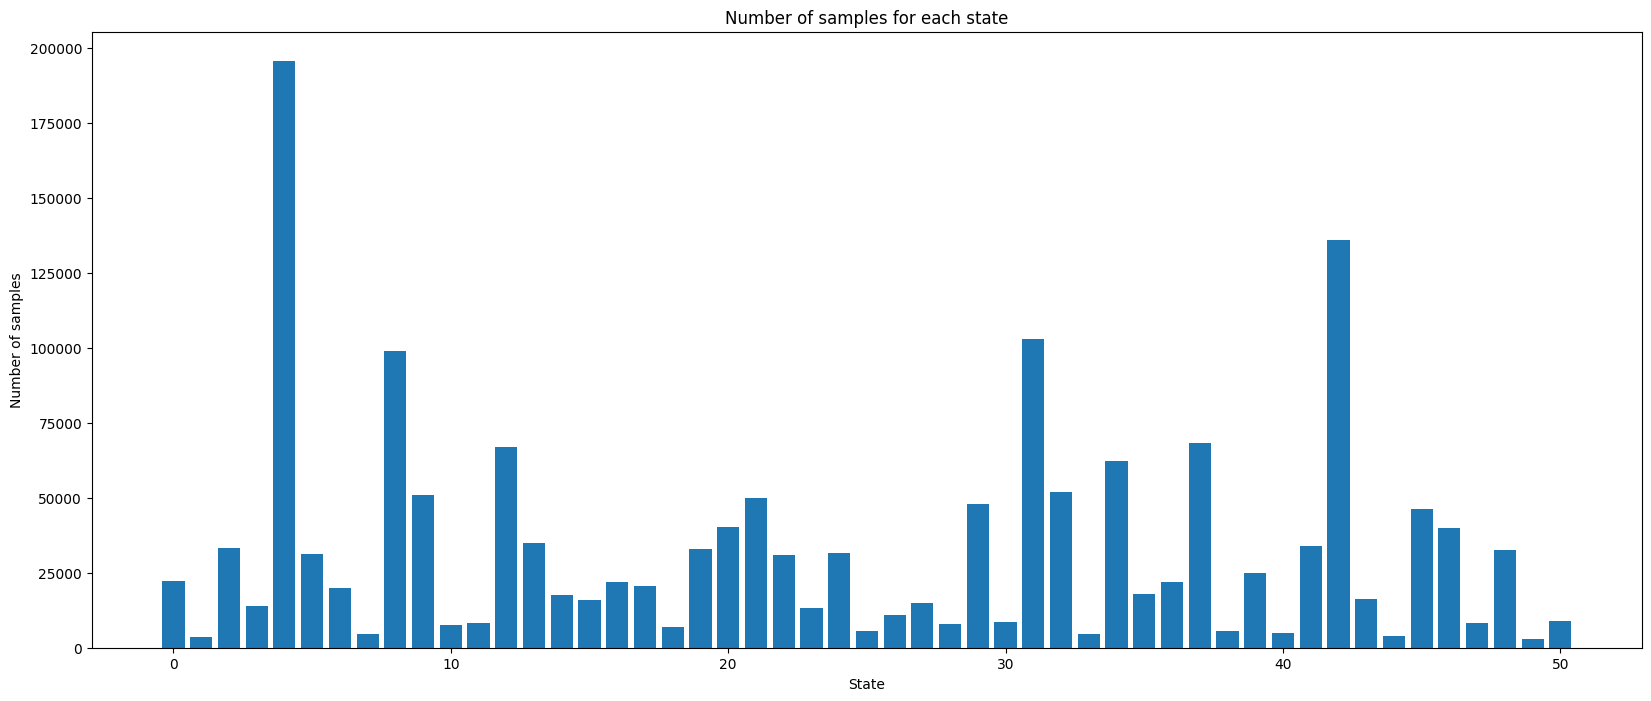

In [7]:
# plot a bar plot with the number of samples for each state
plt.figure(figsize=(20, 8))
plt.bar(range(len(num_samples)), num_samples)
plt.xlabel("State")
plt.ylabel("Number of samples")
plt.title("Number of samples for each state")
plt.show()

Mean of disparities: 0.16020295940668366
STD of disparities: 0.03814889784633062


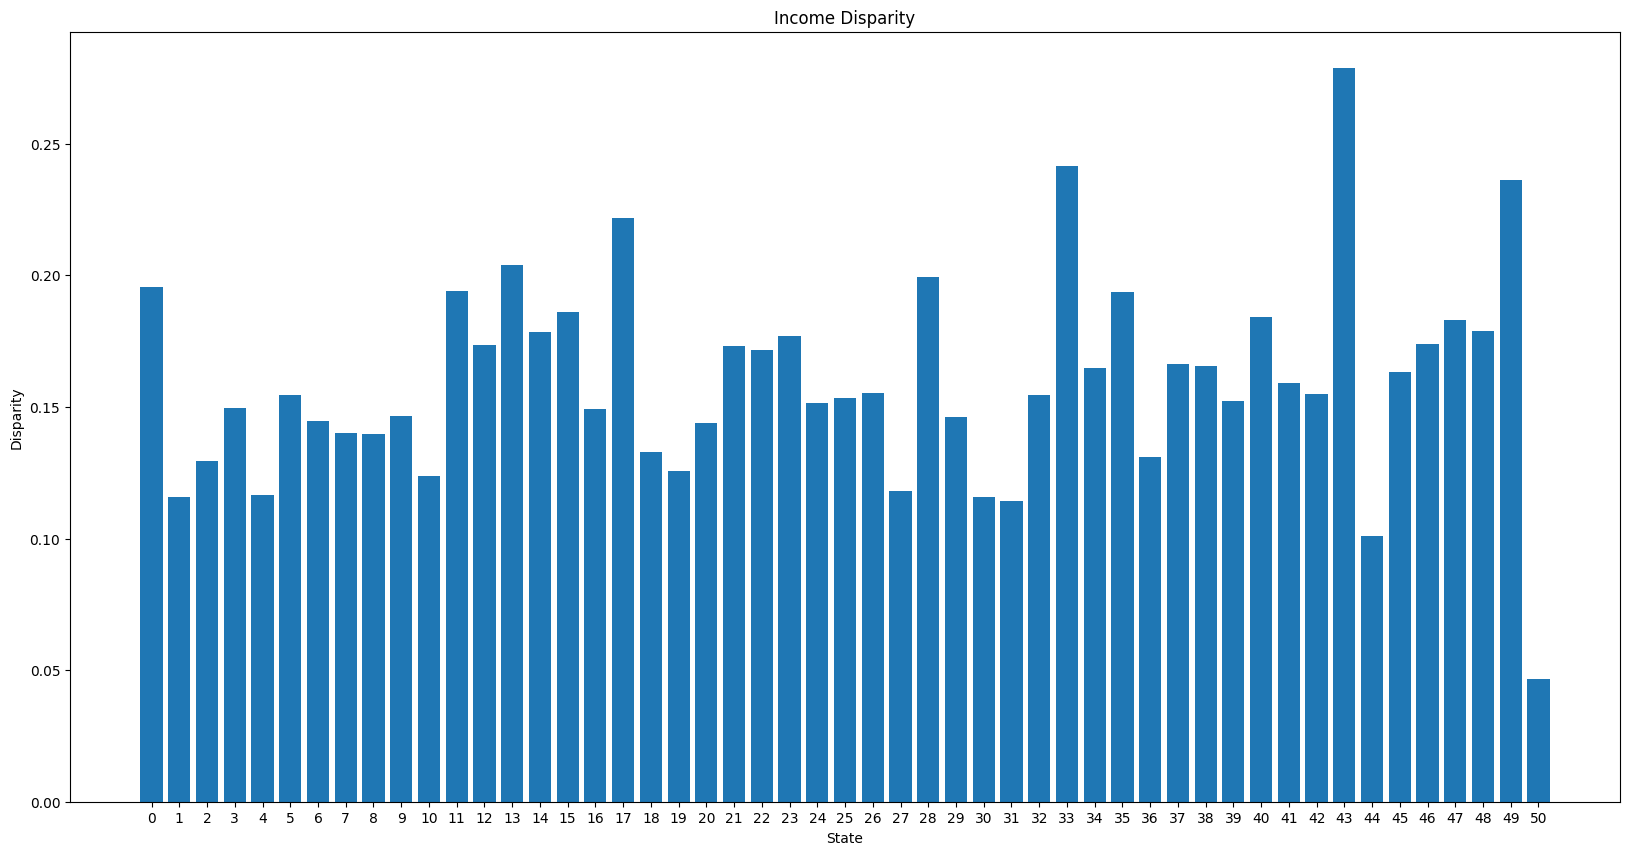

In [8]:
plot_disparity(disparities)

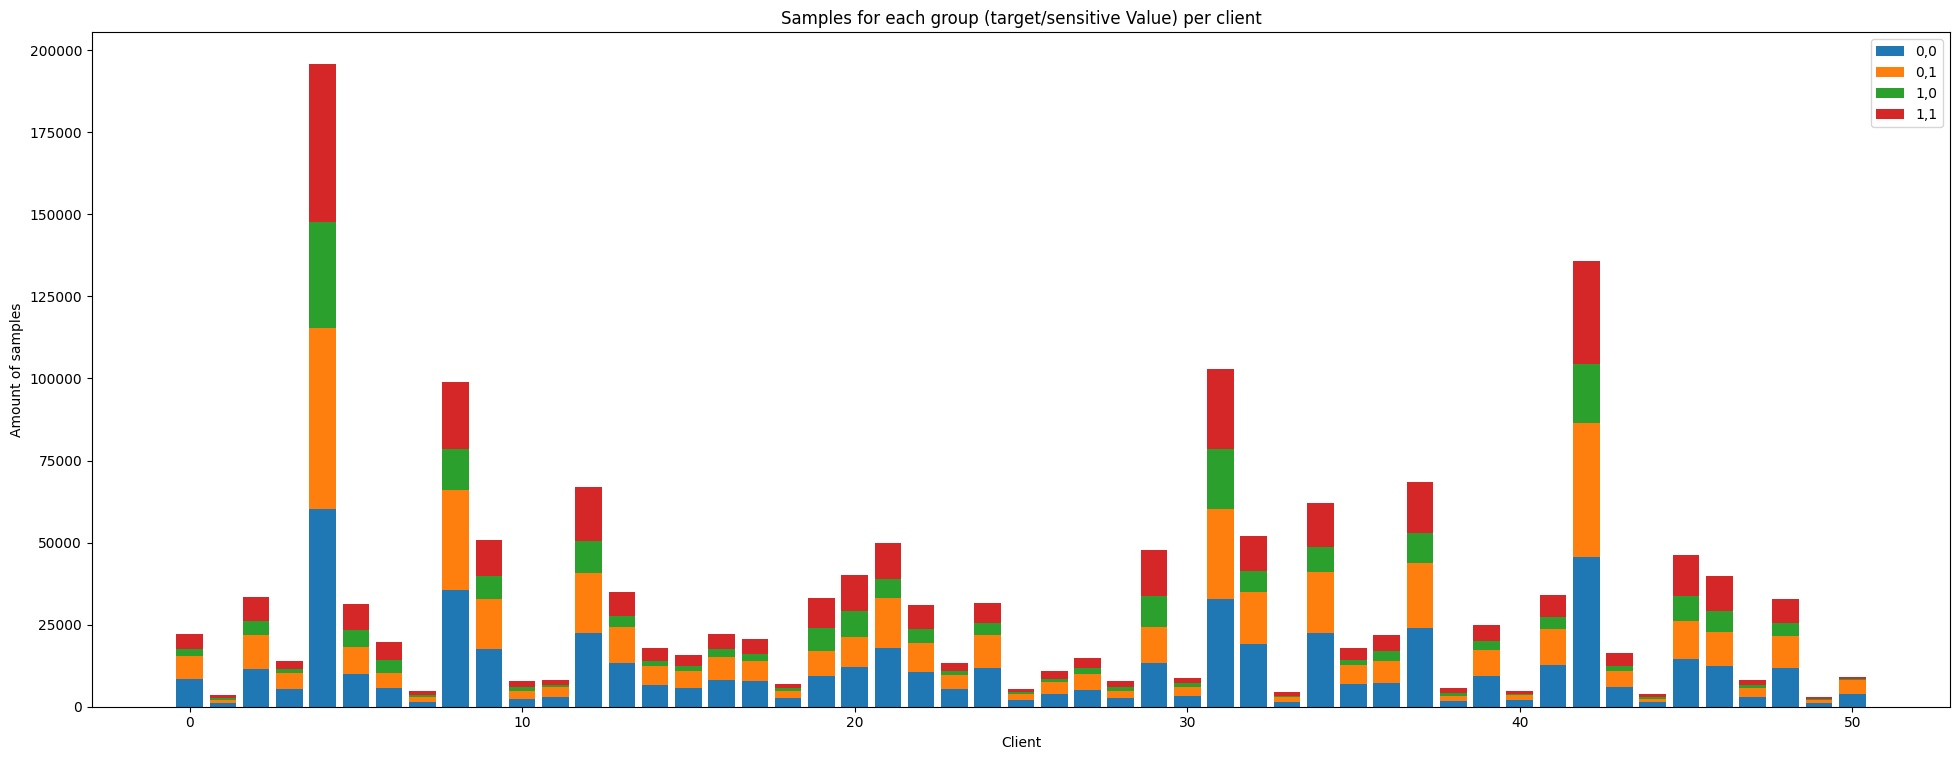

In [9]:
plot_bar_plot(combinations)

# With Filtered Dataset

In [10]:
disparities = {}
for name, dictionary in data_filtered.items():
    labels = torch.tensor(dictionary["labels"].astype(int))
    group = torch.tensor([1 if item == 1 else 0 for item in list(dictionary["groups"])])
    max_disparity = np.max(
                [
                    compute_violation_with_argmax(
                        predictions_argmax=labels,
                        sensitive_attribute_list=group,
                        current_target=target,
                        current_sensitive_feature=sv,
                    )
                    for target in range(0, 1)
                    for sv in range(0, 1)
                ]
            )
    disparities[name] = max_disparity

In [11]:
data = {}
combinations = []
for i in range(51):
    try:
        labels = data_filtered[int(i)].get('labels')
        groups = data_filtered[int(i)].get('groups')
        combinations.append([(l[0], g[0]) for l, g in zip(labels, groups)])
    except:
        continue

Mean of disparities: 0.1589235305694665
STD of disparities: 0.03503353019307688


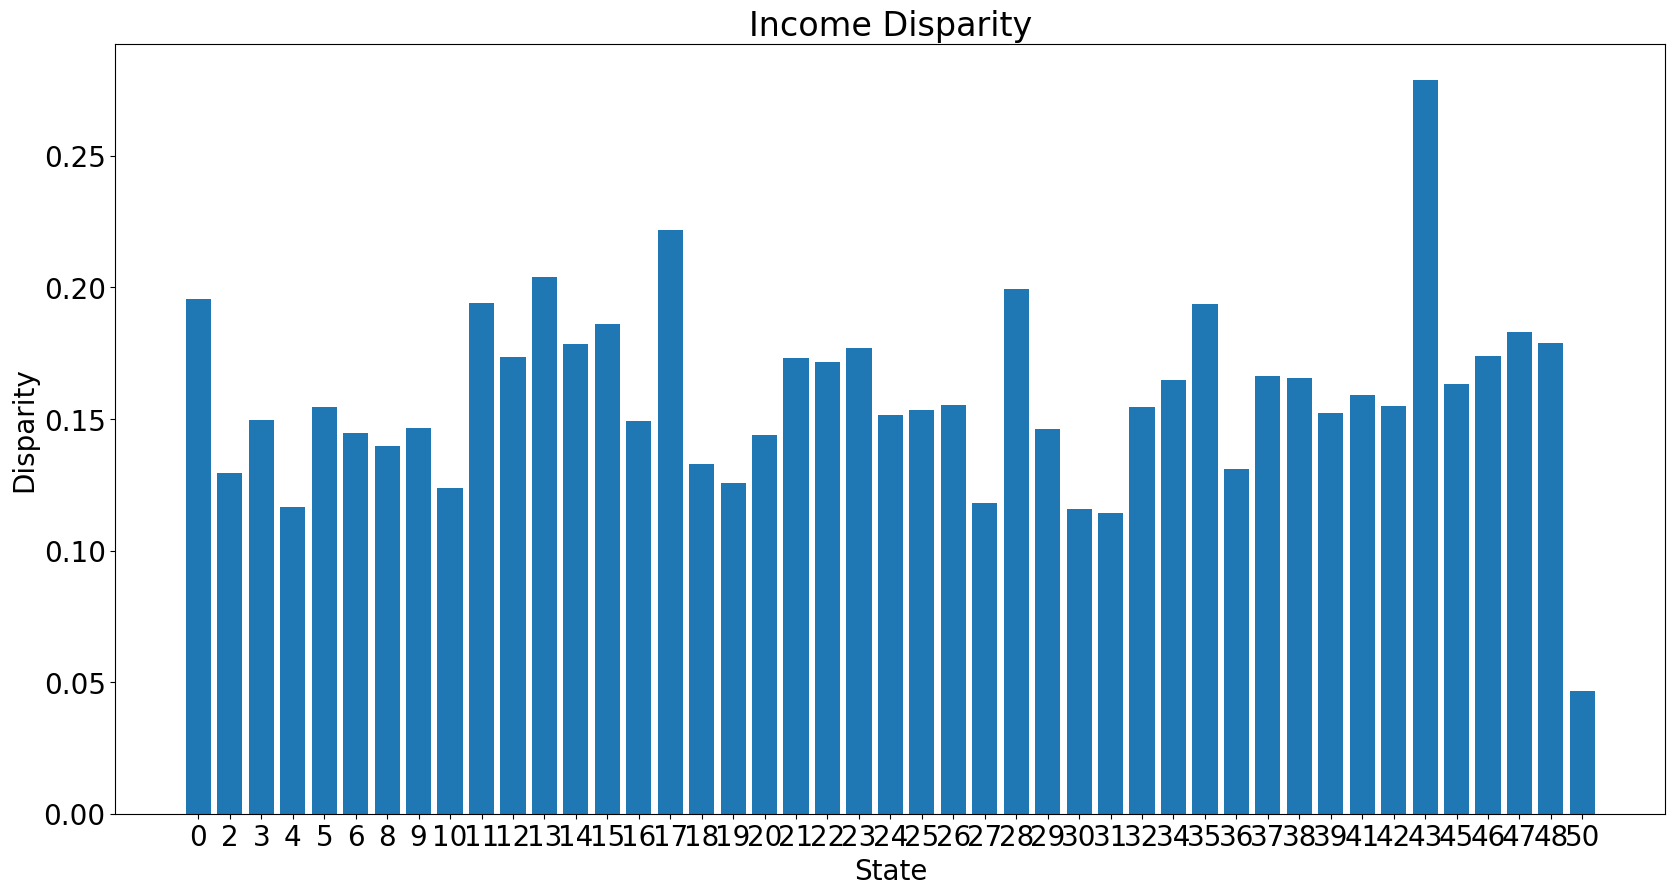

In [12]:
plot_disparity(disparities)

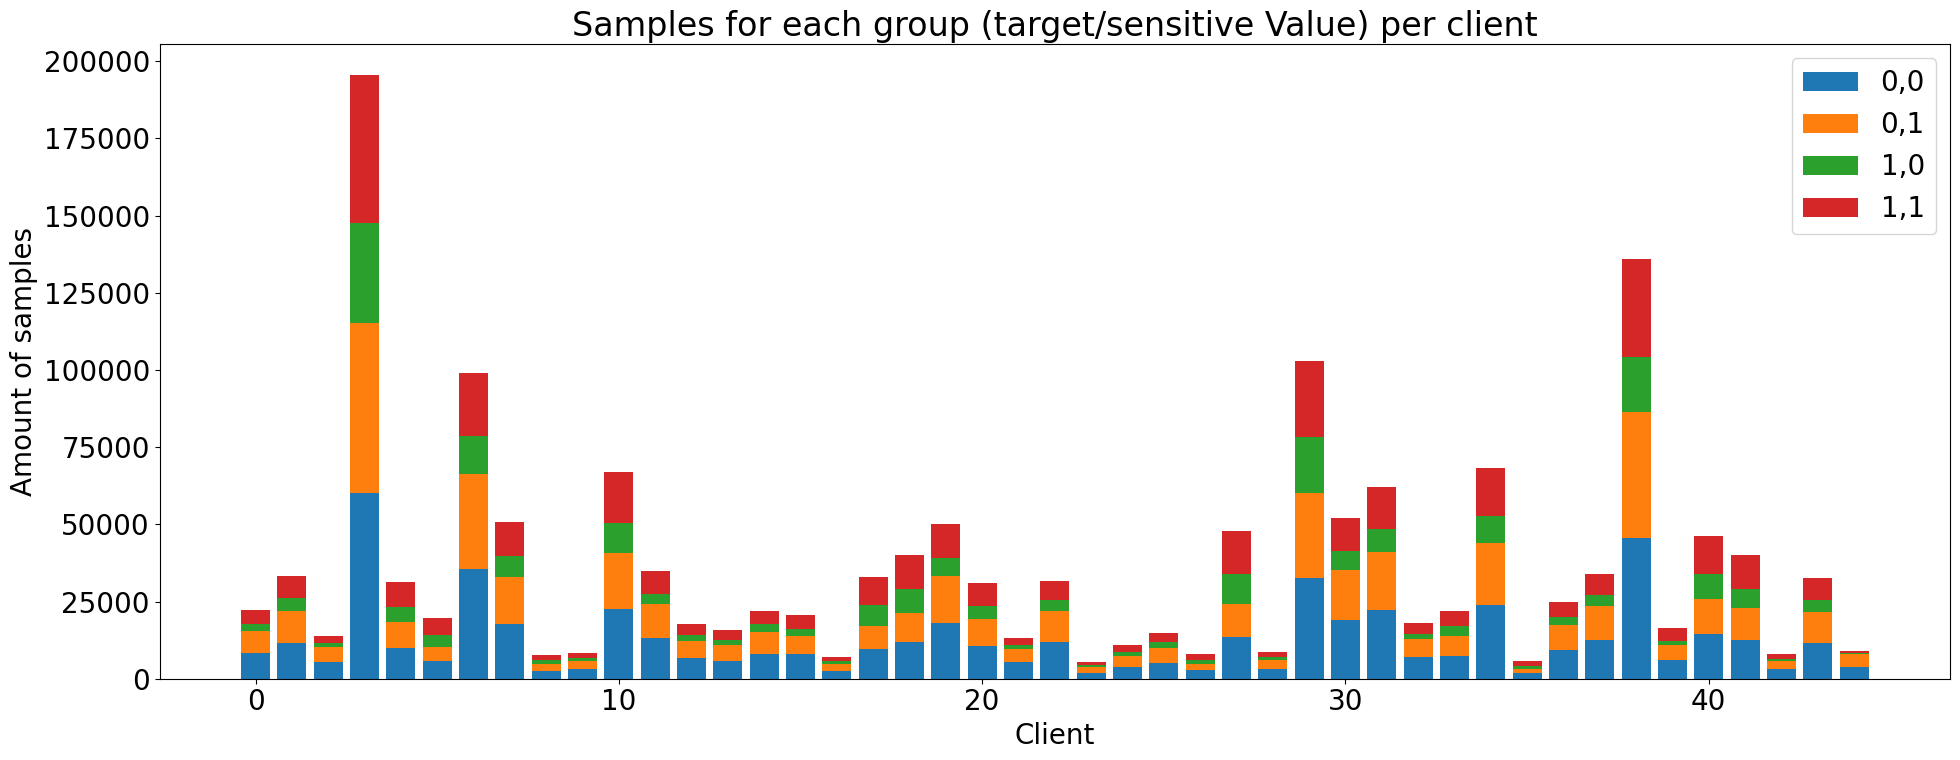

In [13]:
plot_bar_plot(combinations)